# Results Analysis & Visualization

**Purpose.** This notebook collects, computes and visualizes the main results from the PyPSA simulations (capacity, generation, prices, congestion, cost recovery and welfare). It is designed to be the single place for reproducible figures and tables used in reports and the thesis.

**Author.** Tim Schubert

**Date.** August 4, 2025

---

### Quick instructions
1. Make sure you activated the project environment (see `environment.yaml`).  
2. Set the `RESULTS_DIR` / `FOLDER` variable in the *Setup & Configuration* cell to point at the run folders you want to analyse.  
3. Run the **Setup** cell (imports, plotting style, helper functions) first — most functions depend on globals defined there.  
4. Execute the analysis cells in order, or run the notebook end-to-end to reproduce all tables and figures.


# Notebook outline

1. **Setup & Configuration**  
   - Imports, plotting style, folders, helpers.  
2. **Data Loading & Preparation**  
   - Load networks and results files, define scenario-wide plotting variables.
3. **Capacity & Technology Analysis**  
   - Total capacity by zone & tech, capacity maps.
4. **Drivers for Capacity Allocation**  
   - Capacity factors, correlation to siting decisions, demand impact.
5. **Demand Metrics**
   - Total demand served, load duration curves.
6. **Market Prices**
   - Average market prices, price duration curves, CO2 prices, temporal patterns, snapshot mapping.
7. **Cost Recovery**
   - Average cost recovery per technology, asset-level CRF.
8. **Congestion & Redispatch**
   - Redispatch volume, redispatch costs, impact of different redispatch components.
9. **Consumer Prices**
   - Average consumer prices per zone.
10. **Other Metrics & Plots**


## 1. Setup & Configuration

This section initializes the analysis environment:

- Imports required libraries (data handling, plotting, geospatial, optimization results).  
- Loads the project configuration (`config.yaml`) to access scenario settings and paths.  
- Defines consistent plotting styles (color palettes, font sizes, layout).  
- Sets up helper functions from the project scripts folder.  


In [1]:
# Data handling
import os
import sys
import yaml
import math
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Geospatial (for maps and flows)
import cartopy.crs as ccrs
import cartopy.feature as cf

# PyPSA
import pypsa

In [2]:
# Load global project configuration
CONFIG_PATH = "../../config/config.yaml"

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

In [3]:
# General plotting defaults
sns.set_theme(style="whitegrid")

mpl.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 100,
})

# Project color palette
palette = sns.color_palette("Set2")

In [4]:
# Import project-specific helpers (e.g., metrics functions)
import get_metrics  # custom metrics module
import redispatch_calculation # module for redispatch volume and cost calculation

# Default results directory (can be overridden below if needed)
RESULTS_DIR = "../../results"

## 2. Data Loading & Preparation

This section loads the PyPSA networks for different model stages and prepares
global definitions for later analysis and plotting.

- **Networks loaded**: input, prepared, capacity optimization (full/limited/semi-flex), dispatch, and redispatch.  
- **Global definitions**: generation/storage technologies, nice display names, color schemes for plots, and active zones.  


In [5]:
# Main scenario folder - Change based on scenario to analyze
FOLDER = "SPLIT-150"

# Paths to network files for main scenario
fp_input = "../../data/input_networks/base_s_471_elec_.nc"
fp_prepared = f"../../results/{FOLDER}/network_prepared-fixed_year+2013.nc"
fp_capopt_full = f"../../results/{FOLDER}/network_solved_full_knowledge-fixed_year+2013.nc"
fp_capopt_limited = f"../../results/{FOLDER}/network_solved_limited_knowledge-fixed_year+2013.nc"
fp_capopt_semiflex = f"../../results/{FOLDER}/network_semi_flexible_solved-fixed_year+2013.nc"
fp_disp = f"../../results/{FOLDER}/network_dispatch-fixed_year+2013-fixed_year+2013.nc"
fp_redisp = f"../../results/{FOLDER}/network_redispatch-fixed_year+2013-fixed_year+2013.nc"

# Load all networks for main scenario
n_input = pypsa.Network(fp_input)
n_prepared = pypsa.Network(fp_prepared)
n_capopt_full = pypsa.Network(fp_capopt_full)
n_capopt_limited = pypsa.Network(fp_capopt_limited)
n_capopt_semiflex = pypsa.Network(fp_capopt_semiflex)
n_disp = pypsa.Network(fp_disp)
n_redisp = pypsa.Network(fp_redisp)

INFO:pypsa.io:Imported network base_s_471_elec_.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units
INFO:pypsa.io:Imported network network_prepared-fixed_year+2013.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network network_solved_full_knowledge-fixed_year+2013.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network network_solved_limited_knowledge-fixed_year+2013.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network network_semi_flexible_solved-fixed_year+2013.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network network_dispatch-fixed_year+2013-fixed_year+2013.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network network_redispatch-fixed_

In [6]:
# Technology groupings
generation_techs = ["OCGT", "solar", "offwind-ac", "onwind"]
storage_techs = ["battery"]
all_techs = generation_techs + storage_techs

# Display names for nicer plots
nice_names = {
    "OCGT": "Gas",
    "solar": "Solar PV",
    "offwind-ac": "Offshore Wind",
    "onwind": "Onshore Wind",
    "battery": "Battery Storage",
}

# Technology colors
tech_colors = {
    "OCGT": "#8c564b",
    "offwind-ac": "#40e0d0",
    "onwind": "#1f77b4",
    "solar": "#ff7f0e",
    "battery": "#d62728",
}

# Zone colors (customized to highlight nodal/zonal differences)
zone_colors = {
    "Nodal": "black",
    "DE1": "#a1acbd",
    "DE2-North": "#3d91d8",
    "DE2-South": "#ad307b",
    "DE3-NorthWest": "#00ccd6",
    "DE3-NorthEast": "#865400",
    "DE3-South": "#ad307b",
    "DE4-NorthWest": "#00ccd6",
    "DE4-NorthEast": "#865400",
    "DE4-West": "#d06c91",
    "DE4-South": "#ad307b",
    "DE5-NorthWest": "#00ccd6",
    "DE5-SchleswigHolstein": "#0ee2b3",
    "DE5-NorthEast": "#865400",
    "DE5-West": "#d06c91",
    "DE5-South": "#ad307b",
}

# Identify active zones across capacity optimization and dispatch
zones_capopt = n_capopt_full.buses["zone"].unique()
zones_disp = n_disp.buses["zone"].unique()
active_zones = np.union1d(zones_capopt, zones_disp)

print("Global definitions prepared. Active zones:", active_zones)


Global definitions prepared. Active zones: ['DE2-North' 'DE2-South' 'Nodal']


## 3. Capacity & Technology Analysis

This section inspects installed capacities and spatial distribution of technologies.

- Tables: total installed capacity per zone and per technology for each scenario stage (capacity optimization, dispatch).  
- Maps: location-wise capacity representation, transmission network (capacity-coded), and optional high-resolution thesis maps.  
- Demand vs generation spatial maps and flow-vs-demand arrows.

In [9]:
# Cell: Compute & display total capacities for scenarios in tabular structure

def display_total_capacities(scenarios, n_ref=None, techs=None, unit="GW"):
    """
    Display total capacities per zone for multiple scenarios.

    Parameters
    ----------
    scenarios : dict
        Mapping name -> pypsa.Network
    n_ref : pypsa.Network or None
        Reference network used for zone definitions. If None, use the first scenario value.
    techs : list[str] or None
        Technologies (carriers) to include. If None, infer from networks.
    unit : str
        Unit label for display; supports 'GW' or 'MW' (converts accordingly).
    """
    conv = 1.0
    if unit == "GW":
        conv = 1e-3
    elif unit == "MW":
        conv = 1.0
    else:
        raise ValueError("unit must be 'GW' or 'MW'")

    # set reference network for zones
    if n_ref is None:
        n_ref = next(iter(scenarios.values()))

    for name, net in scenarios.items():
        # call the existing helper in get_metrics
        caps = get_metrics.get_capacities_per_zone(net, n_ref, techs if techs is not None else all_techs)
        display_df = caps.T * conv
        display_df = display_df.round(2)
        print(f"\n{name} — total capacities ({unit})")
        display(display_df)


# Build dictionary of scenarios we want to present
scenarios = {
    "Full Knowledge Cap. Opt.": n_capopt_full,
    "Limited Knowledge Cap. Opt.": n_capopt_limited,
    "Semi-Flex Cap. Opt.": n_capopt_semiflex,
    "Dispatch Simulation": n_disp
}

n_ref_for_zones = n_disp
display_total_capacities(scenarios, n_ref=n_ref_for_zones, techs=all_techs, unit="GW")


Full Knowledge Cap. Opt. — total capacities (GW)


,OCGT,solar,offwind-ac,onwind,battery
DE3-South,29.34,66.80,0.00,37.20,7.25
DE3-NorthWest,13.82,36.04,0.00,48.52,12.31
DE3-NorthEast,1.90,57.38,2.08,20.69,8.06



Limited Knowledge Cap. Opt. — total capacities (GW)


,OCGT,solar,offwind-ac,onwind,battery
DE3-South,29.34,82.52,0.00,42.05,7.25
DE3-NorthWest,13.82,1.67,0.00,56.03,12.31
DE3-NorthEast,1.90,81.78,2.08,3.29,8.06



Semi-Flex Cap. Opt. — total capacities (GW)


,OCGT,solar,offwind-ac,onwind,battery
DE3-South,29.34,62.36,0.00,6.22,7.25
DE3-NorthWest,13.82,0.00,0.00,55.88,12.31
DE3-NorthEast,1.90,49.96,2.08,0.00,8.06



Dispatch Simulation — total capacities (GW)


,OCGT,solar,offwind-ac,onwind,battery
DE3-South,29.34,62.36,0.00,6.22,7.25
DE3-NorthWest,13.82,0.00,0.00,55.88,12.31
DE3-NorthEast,1.90,49.96,2.08,0.00,8.06


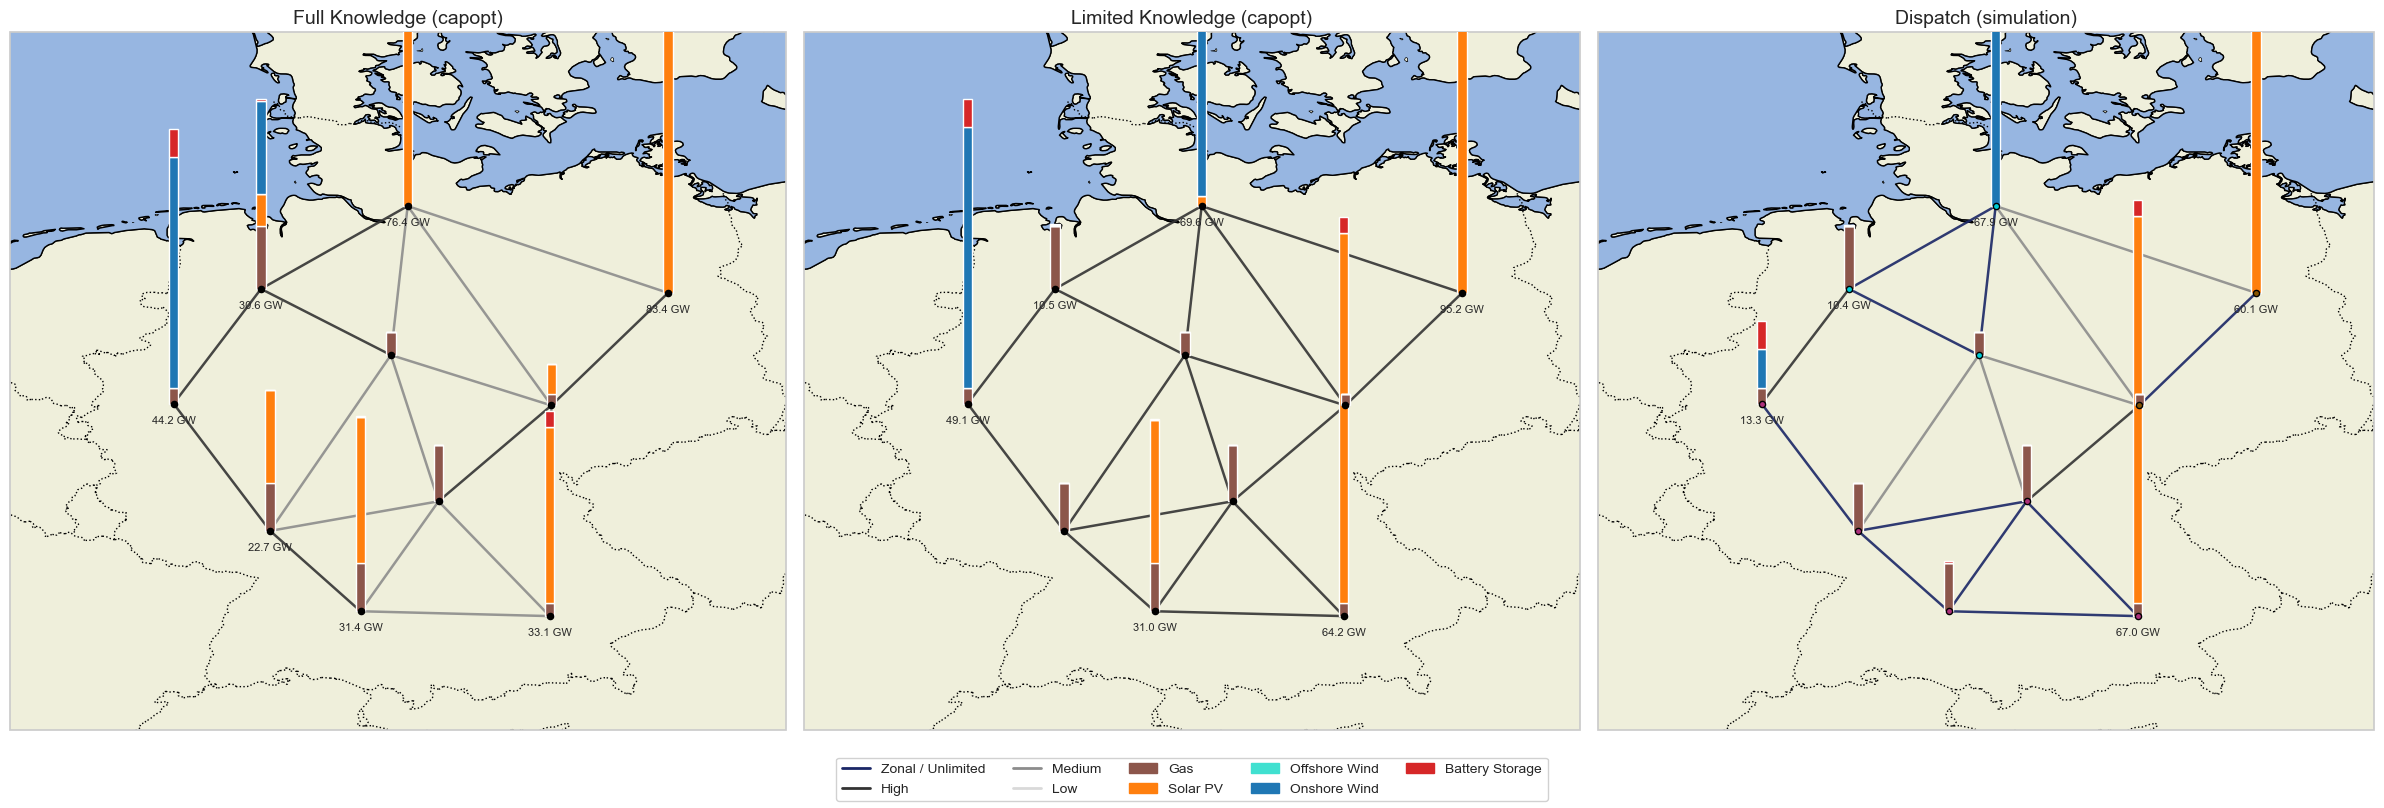

In [10]:
# Cell: Multi-Panel Capacity Maps (e.g. Full Knowledge / Limited Knowledge / Dispatch)
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

def setup_map(ax, extent=[5, 15, 47, 56]):
    """Set common map features on an axis"""
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cf.BORDERS, linestyle=':')
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.LAND, edgecolor='black', zorder=0)
    ax.add_feature(cf.OCEAN, zorder=0)

def _line_color_from_capacity(s_nom, attr="s_nom_opt"):
    """
    Small helper to map line capacity value -> color (kept simple but expressive).
    Uses thresholds to choose dark/medium/light grey or special color for zonal/unlimited.
    """
    # treat very large as unlimited/zonal
    if s_nom is None:
        return "silver"
    if s_nom >= 1e8:
        return (0.1, 0.15, 0.4)  # special: zonal/unlimited
    if s_nom >= 10000:
        return (0.2, 0.2, 0.2)
    if s_nom >= 1000:
        return (0.55, 0.55, 0.55)
    return (0.85, 0.85, 0.85)

def plot_network_capacities(net, ax, title=None, scaling_factor=0.00008, bar_width=0.12,
                            line_attr="s_nom_opt", annotate_threshold_mw=10000):
    """
    Plot capacity bars at bus locations and draw lines colored by capacity.

    Parameters
    ----------
    net : pypsa.Network
    ax : matplotlib axis with PlateCarree projection
    scaling_factor : float
        Factor applied to capacities for plotting marker heights (tune per figure size).
    bar_width : float
    line_attr : str
        's_nom_opt' (use optimization result) or 's_nom'.
    annotate_threshold_mw : numeric
        If total capacity at a bus > threshold (MW), display the label in GW.
    """
    setup_map(ax)
    bus_locs = net.buses[['x', 'y']]
    gen_caps = net.generators.groupby(['bus', 'carrier'])['p_nom_opt'].sum().unstack(fill_value=0)
    storage_caps = net.storage_units.groupby(['bus', 'carrier'])['p_nom_opt'].sum().unstack(fill_value=0)

    # plot bus points and stacked bars per tech
    for bus, (x, y) in bus_locs.iterrows():
        zone = net.buses.loc[bus, "zone"] if "zone" in net.buses.columns else "Nodal"
        ax.scatter(x, y, s=20, color=zone_colors.get(zone, "k"),
                   edgecolor='black', zorder=15, transform=ccrs.PlateCarree())

        bottom = y
        total_mw = 0.0
        # plot generation columns (stacked)
        for tech in generation_techs + storage_techs:
            if tech not in gen_caps.columns and tech not in storage_caps.columns:
                continue
            cap_mw = 0.0
            if tech in gen_caps.columns and bus in gen_caps.index:
                cap_mw += gen_caps.at[bus, tech]
            if tech in storage_caps.columns and bus in storage_caps.index:
                cap_mw += storage_caps.at[bus, tech]
            if cap_mw <= 0:
                continue
            height = cap_mw * scaling_factor
            ax.bar(x, height, bar_width, bottom=bottom, color=tech_colors.get(tech, "gray"),
                   transform=ccrs.PlateCarree(), zorder=8)
            bottom += height
            total_mw += cap_mw
        if total_mw >= annotate_threshold_mw:
            ax.text(x, y - 0.25, f"{total_mw/1000:.1f} GW", fontsize=8, ha='center', transform=ccrs.PlateCarree(), zorder=14)

    # plot lines
    for _, line in net.lines.iterrows():
        try:
            x0, y0 = net.buses.loc[line.bus0, ['x', 'y']]
            x1, y1 = net.buses.loc[line.bus1, ['x', 'y']]
        except Exception:
            continue
        s_nom = getattr(line, line_attr, None)
        color = _line_color_from_capacity(s_nom)
        ax.plot([x0, x1], [y0, y1], linewidth=1.8, color=color, alpha=0.9, zorder=7, transform=ccrs.PlateCarree())

    if title:
        ax.set_title(title, fontsize=14, pad=6)


# Panel figure: Full / Limited / Dispatch - Define simulation stages here
fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_network_capacities(n_capopt_full, axes[0], title="Full Knowledge (capopt)")
plot_network_capacities(n_capopt_limited, axes[1], title="Limited Knowledge (capopt)")
plot_network_capacities(n_disp, axes[2], title="Dispatch (simulation)")

# legend: tech patches + line examples
tech_handles = [mpatches.Patch(color=tech_colors[t], label=nice_names.get(t, t)) for t in generation_techs + storage_techs]
line_handles = [
    Line2D([0], [0], color=(0.1,0.15,0.4), lw=2, label="Zonal / Unlimited"),
    Line2D([0], [0], color=(0.2,0.2,0.2), lw=2, label="High"),
    Line2D([0], [0], color=(0.55,0.55,0.55), lw=2, label="Medium"),
    Line2D([0], [0], color=(0.85,0.85,0.85), lw=2, label="Low"),
]

fig.legend(handles=line_handles + tech_handles, loc='lower center', ncol=5, framealpha=0.9)
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()

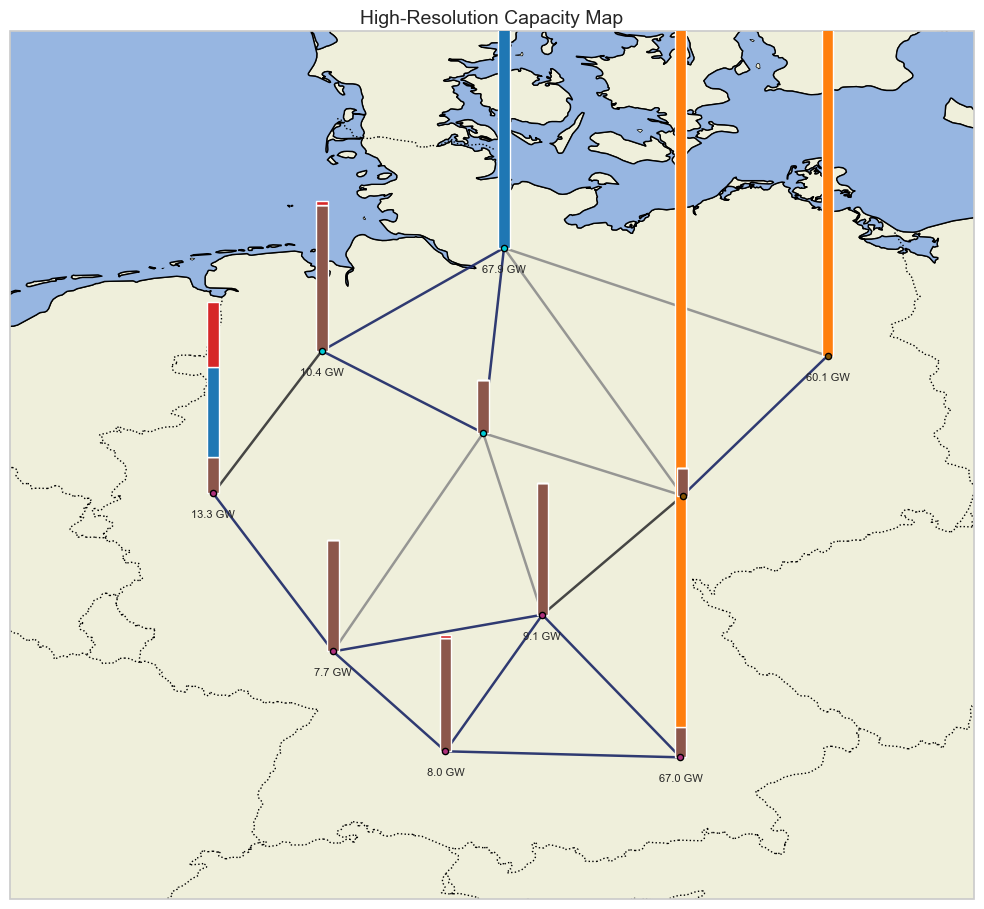

In [12]:
# Plot high-resolution map (single panel)
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_network_capacities(n_disp, # define simulation stage
                        ax,
                        title="High-Resolution Capacity Map",
                        scaling_factor=0.00015,
                        annotate_threshold_mw=7000)
plt.tight_layout()
plt.show()

/var/folders/b8/z9v18hmn4x58qcsgkfvfd24h0000gn/T/ipykernel_4949/3435684936.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gen = net.generators_t.p.groupby(net.generators.bus, axis=1).sum()
/var/folders/b8/z9v18hmn4x58qcsgkfvfd24h0000gn/T/ipykernel_4949/3435684936.py:17: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  load = net.loads_t.p_set.groupby(net.loads.bus, axis=1).sum()


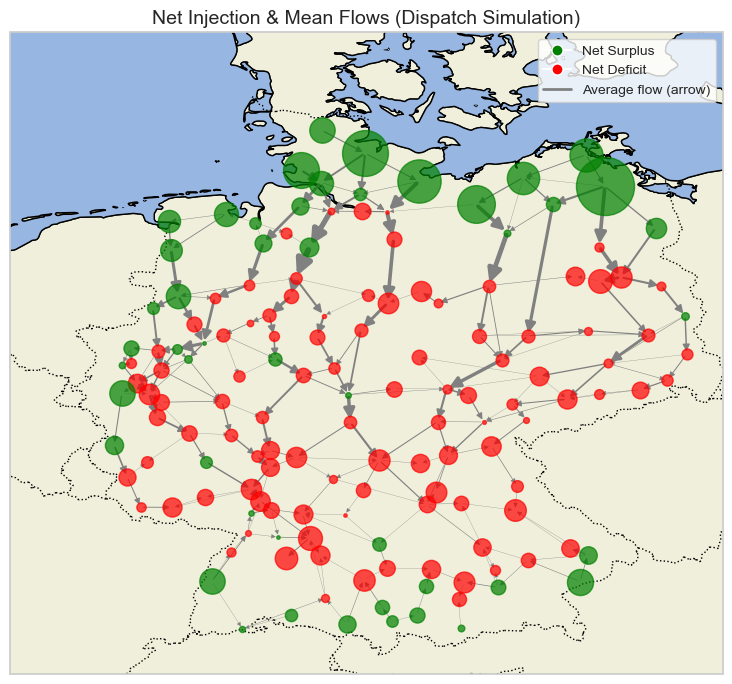

In [12]:
# Cell: Plot visual representation of demand vs. supply nodes and average flows

def plot_flow_vs_demand(net, ax=None, title=None, flow_scale=0.001, injection_scale=0.4):
    """
    Plot average net injection (generation - load) as colored circles, and average line flows as arrows.
    """
    from matplotlib.patches import FancyArrowPatch
    from matplotlib.lines import Line2D

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})

    setup_map(ax)

    # net injection per bus (avg)
    gen = net.generators_t.p.groupby(net.generators.bus, axis=1).sum()
    load = net.loads_t.p_set.groupby(net.loads.bus, axis=1).sum()
    # align: if a bus has no load/generation time series, fill with zeros
    try:
        net_injection = (gen.reindex(columns=net.buses.index, fill_value=0) - load.reindex(columns=net.buses.index, fill_value=0)).mean(axis=0)
    except Exception:
        # fallback safe method
        net_injection = pd.Series(0.0, index=net.buses.index)

    for bus, val in net_injection.items():
        if bus not in net.buses.index:
            continue
        x, y = net.buses.loc[bus, ['x', 'y']]
        color = 'green' if val > 0 else 'red'
        size = abs(val) * injection_scale
        ax.scatter(x, y, s=size, color=color, alpha=0.7, transform=ccrs.PlateCarree(), zorder=12)

    # flows averaged over time (use p0 or p1 columns depending on your model)
    # flows is a Series indexed by line id (matching net.lines.index)
    if hasattr(net, "lines_t") and getattr(net, "lines_t", None) is not None:
        flows = net.lines_t.p0.mean(axis=0) if "p0" in net.lines_t else (net.lines_t.mean(axis=0) if not net.lines_t.empty else pd.Series(dtype=float))
    else:
        flows = pd.Series(dtype=float)

    for line_id, flow in flows.items():
        if line_id not in net.lines.index:
            continue
        line = net.lines.loc[line_id]
        try:
            x0, y0 = net.buses.loc[line.bus0, ['x', 'y']]
            x1, y1 = net.buses.loc[line.bus1, ['x', 'y']]
        except Exception:
            continue

        # width and arrow direction
        width = max(0.2, abs(flow) * flow_scale)
        color = 'grey'
        if flow >= 0:
            start = (x0, y0); end = (x1, y1)
        else:
            start = (x1, y1); end = (x0, y0)

        arrow = FancyArrowPatch(start, end, arrowstyle='-|>', color=color, linewidth=width, mutation_scale=6 + width*4, transform=ccrs.PlateCarree(), zorder=6)
        ax.add_patch(arrow)

    # legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Net Surplus', markerfacecolor='green', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Net Deficit', markerfacecolor='red', markersize=8),
        Line2D([0], [0], color='grey', lw=2, label='Average flow (arrow)')
    ]
    ax.legend(handles=legend_elements, loc='best')

    if title:
        ax.set_title(title, fontsize=14)
    return ax

fig, ax = plt.subplots(1, 1, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
plot_flow_vs_demand(n_disp, # Define simulation stage here
                    ax, title="Net Injection & Mean Flows (Dispatch Simulation)")
plt.tight_layout()
plt.show()

## 4. Drivers for Capacity Allocation

This section explores how different factors shape capacity placement through three key perspectives:

1. **Capacity Factors** – average utilization of renewable assets across locations.  
2. **Capacity Potential Correlation** – relationship between siting, capacity factors, and installed capacity.  
3. **Electricity Demand** - visual representation of how close generation is sited in relation to demand centers.

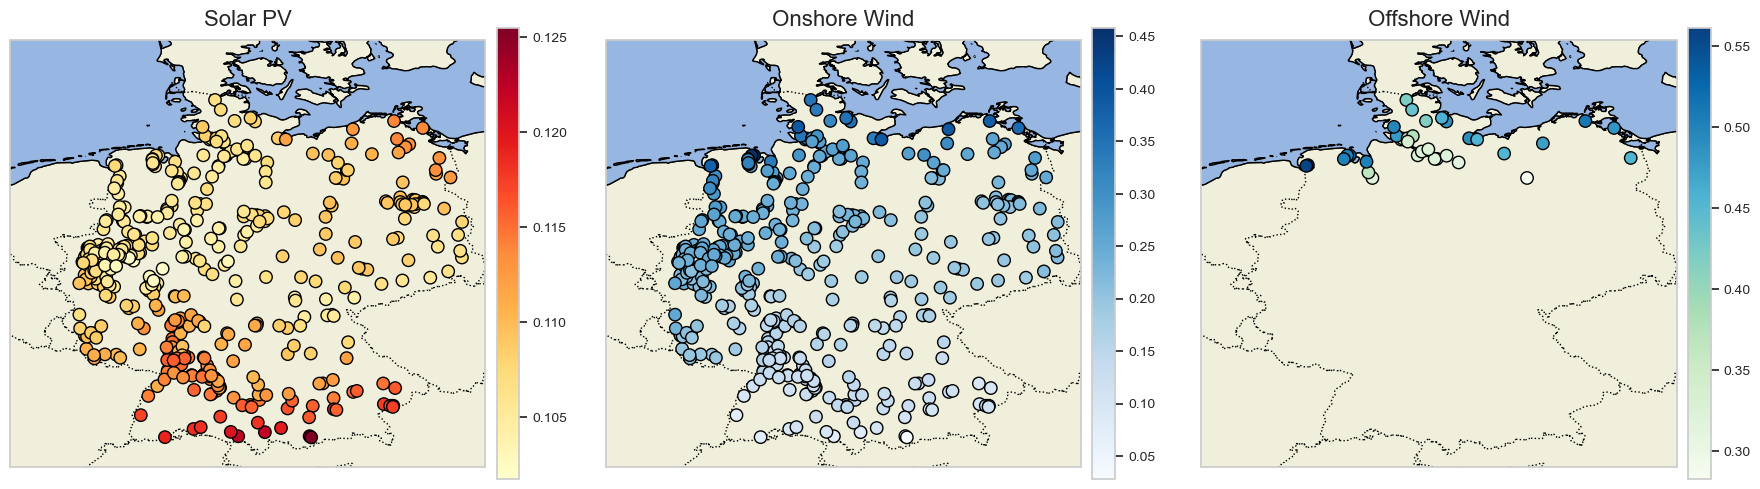

In [13]:
# Cell: Plot capacity factors for renewables at each node
import matplotlib.colors as colors

def plot_carrier_capacity_factors(net, ax, carrier, title=None):
    """
    Plot average capacity factors for a given carrier across the network.
    
    Parameters
    ----------
    net : pypsa.Network
        The network object containing results.
    ax : matplotlib axis
        Axis object for plotting.
    carrier : str
        Technology carrier (e.g., 'solar', 'onwind', 'offwind-ac').
    title : str, optional
        Title for the subplot.
    """
    # Choose colormap
    cmap_dict = {
        "solar": mpl.colormaps.get_cmap("YlOrRd"),
        "onwind": mpl.colormaps.get_cmap("Blues"),
        "offwind-ac": mpl.colormaps.get_cmap("GnBu"),
    }
    cmap = cmap_dict.get(carrier, mpl.colormaps.get_cmap("viridis"))

    # Select generators
    gens = net.generators[net.generators.carrier == carrier]
    cf_mean = net.generators_t.p_max_pu[gens.index].mean(axis=0)

    # Bus coordinates with CF
    bus_coords = net.buses.loc[gens.bus, ["x", "y"]].copy()
    bus_coords["cf"] = cf_mean.values

    # Map setup
    ax.set_extent([5, 15, 47, 56], crs=ccrs.PlateCarree())
    ax.add_feature(cf.BORDERS, linestyle=":")
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.LAND, edgecolor="black")
    ax.add_feature(cf.OCEAN)

    # Normalize and scatter
    norm = colors.Normalize(vmin=bus_coords["cf"].min(), vmax=bus_coords["cf"].max())
    ax.scatter(
        bus_coords.x,
        bus_coords.y,
        s=80,
        c=cmap(norm(bus_coords.cf)),
        edgecolor="black",
        transform=ccrs.PlateCarree(),
        zorder=15,
    )

    # Colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation="vertical", pad=0.02, shrink=0.8)

    if title:
        ax.set_title(title, fontsize=16, pad=10)


fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()}
)

plot_carrier_capacity_factors(n_input, axes[0], "solar", title="Solar PV")
plot_carrier_capacity_factors(n_input, axes[1], "onwind", title="Onshore Wind")
plot_carrier_capacity_factors(n_input, axes[2], "offwind-ac", title="Offshore Wind")

plt.tight_layout()
plt.show()

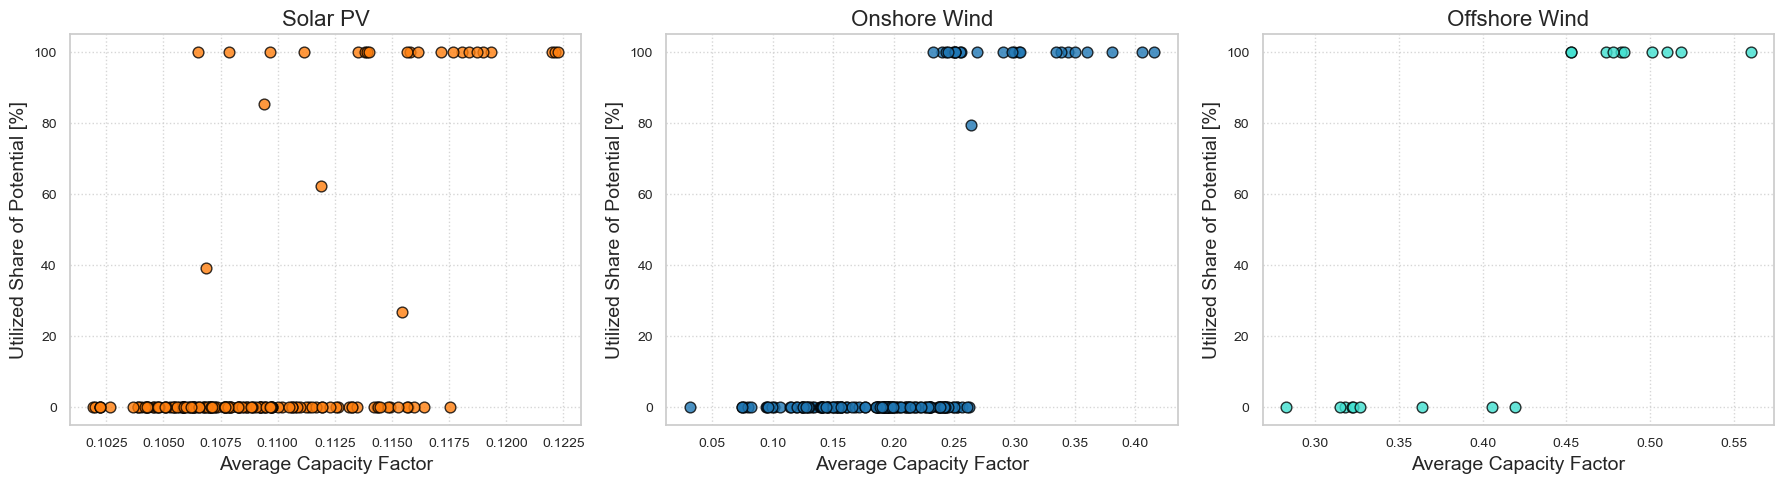

In [14]:
# Cell: Visualize correlation between renewable capacity factors and potential utilization

def plot_cf_vs_capacity_scatter(net, carriers, tech_colors):
    """
    Scatter plot of average capacity factor vs. utilized share of potential capacity.
    
    Parameters
    ----------
    net : pypsa.Network
        Optimized network.
    carriers : list of str
        List of technologies to plot.
    tech_colors : dict
        Mapping of carrier names to colors.
    """
    fig, axes = plt.subplots(1, len(carriers), figsize=(6 * len(carriers), 5))

    if len(carriers) == 1:
        axes = [axes]

    for ax, carrier in zip(axes, carriers):
        gens = net.generators[net.generators.carrier == carrier]
        cf_mean = net.generators_t.p_max_pu[gens.index].mean(axis=0)
        cap, max_cap = gens.p_nom_opt, gens.p_nom_max

        x = cf_mean.values
        y = (cap.values / max_cap.values) * 100
        color = tech_colors.get(carrier, "gray")

        ax.scatter(x, y, s=60, color=color, edgecolor="black", alpha=0.8)

        ax.set_ylim(-5, 105)
        ax.set_title(nice_names.get(carrier, carrier), fontsize=16)
        ax.set_xlabel("Average Capacity Factor", fontsize=14)
        ax.set_ylabel("Utilized Share of Potential [%]", fontsize=14)
        ax.grid(True, linestyle=":", alpha=0.8)

    plt.tight_layout()
    plt.show()

plot_cf_vs_capacity_scatter(
    n_capopt_semiflex, # Define simulation stage here
    ["solar", "onwind", "offwind-ac"], tech_colors
)

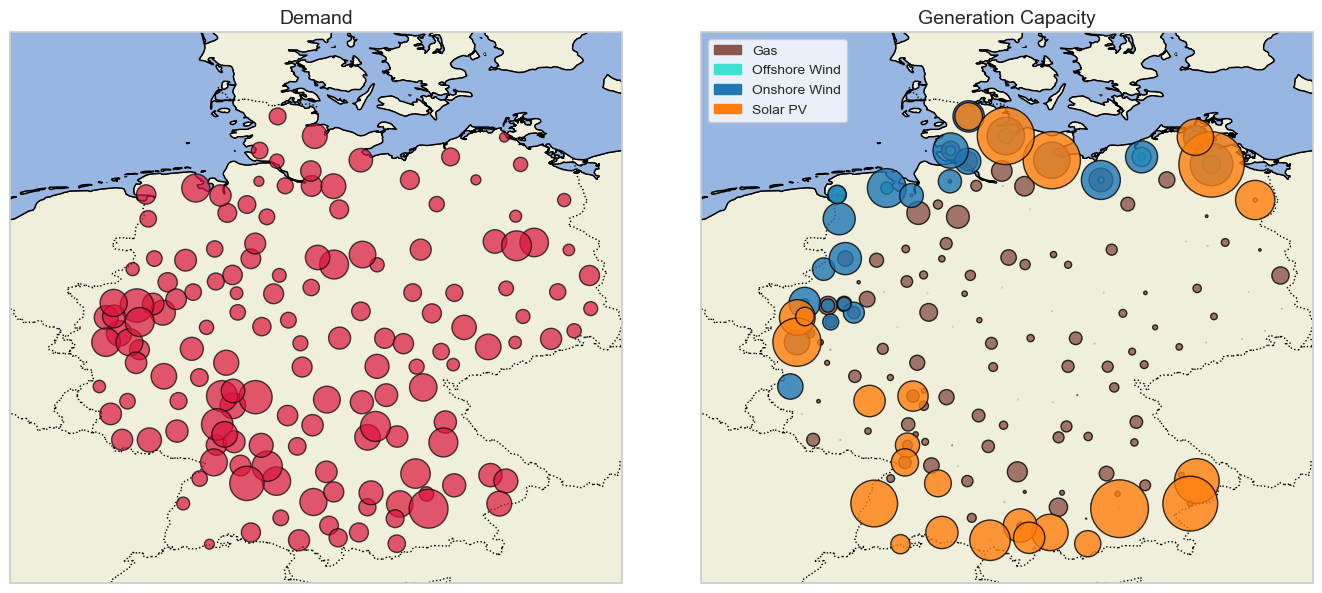

In [15]:
# Cell: Visualize locations of demand centers vs. generation technologies

def plot_demand_and_generation_by_tech(net, tech_colors=tech_colors, title_left="Demand", title_right="Generation Capacity"):
    """
    Left: bubble map with average load per bus.
    Right: bubble map with capacity per technology (scatter per generator).
    """
    # prepare loads
    avg_loads = net.loads_t.p_set.mean(axis=0)
    loads_df = net.loads.copy()
    loads_df['avg_load'] = loads_df.index.map(lambda idx: avg_loads.get(idx, 0.0))
    loads_df['x'] = net.buses.loc[loads_df['bus'], 'x'].values
    loads_df['y'] = net.buses.loc[loads_df['bus'], 'y'].values

    # prepare generators
    gens = net.generators.copy()
    gens['x'] = net.buses.loc[gens['bus'], 'x'].values
    gens['y'] = net.buses.loc[gens['bus'], 'y'].values

    # plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax = axes[0]
    setup_map(ax)
    sizes = (loads_df['avg_load'].fillna(0).values) * 0.6
    ax.scatter(loads_df['x'], loads_df['y'], s=sizes, color='crimson', alpha=0.7, edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)
    ax.set_title(title_left, fontsize=14)

    ax = axes[1]
    setup_map(ax)
    for tech, group in gens.groupby('carrier'):
        if tech not in tech_colors:
            continue
        sizes = (group['p_nom_opt'].fillna(0).values) * 0.12
        ax.scatter(group['x'], group['y'], s=sizes, color=tech_colors[tech], alpha=0.8, edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)

    # legend
    tech_handles = [mpatches.Patch(color=tech_colors[t], label=nice_names.get(t, t)) for t in tech_colors if t in gens['carrier'].unique()]
    axes[1].legend(handles=tech_handles, loc='upper left', fontsize=10)
    axes[1].set_title(title_right, fontsize=14)

    plt.tight_layout()
    plt.show()

plot_demand_and_generation_by_tech(n_capopt_semiflex) # Define simulation stage here

## 5. Demand Metrics

This section evaluates electricity demand patterns.

1. **Total Demand Served** – comparison of total annual demand supplied in each bidding zone.  
2. **Load Duration Curves (LDCs)** – analysis of demand distribution over time, comparing multiple scenarios.

In [16]:
# Cell: Display total demand served per zone and scenario in tabular format

# Define scenarios
nets = [n_capopt_full, n_capopt_limited, n_capopt_semiflex, n_disp]
names = [
    "Full Knowledge Capacity Optimization",
    "Limited Knowledge Capacity Optimization",
    "Semi-Flexible Capacity Optimization",
    "Dispatch Simulation",
]

# Aggregate demand served
zone_totals = {}
for net, name in zip(nets, names):
    zone_ldc = get_metrics.get_sorted_zone_ldc(net, n_disp)
    for zone, ldc in zone_ldc.items():
        zone_totals.setdefault(zone, {})[name] = ldc.sum() / 1e6  # convert to TWh

# Convert to DataFrame
df_zone_totals = pd.DataFrame(zone_totals).T[names].round(1)
df_zone_totals.loc["Total"] = df_zone_totals.sum()

print("Total Demand Served [TWh]")
display(df_zone_totals)

Total Demand Served [TWh]


,Full Knowledge Capacity Optimization,Limited Knowledge Capacity Optimization,Semi-Flexible Capacity Optimization,Dispatch Simulation
DE2-North,185.3,185.3,177.9,177.5
DE2-South,322.8,322.8,309.8,308.4
Total,508.1,508.1,487.7,485.9


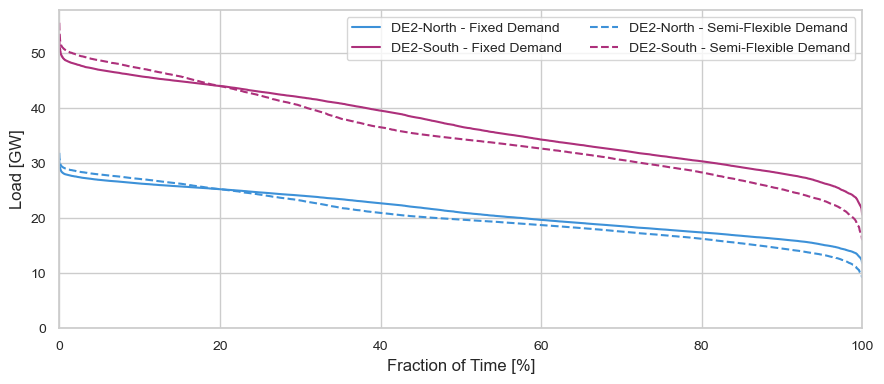

In [17]:
# Cell: Plot load duraction curves

def plot_ldc_comparison(nets, titles, zone_reference_net, figsize=(9, 4)):
    """
    Plot load duration curves (LDCs) for different scenarios.

    Parameters
    ----------
    nets : list of pypsa.Network
        List of networks to compare.
    titles : list of str
        Scenario labels matching `nets`.
    zone_reference_net : pypsa.Network
        Network used as a reference for zones (usually the dispatch model).
    figsize : tuple, optional
        Figure size (default: (9, 4)).
    """
    linestyles = ["-", "--", "-."]
    fig, ax = plt.subplots(figsize=figsize)

    for net, title, linestyle in zip(nets, titles, linestyles):
        zone_ldcs = get_metrics.get_sorted_zone_ldc(net, zone_reference_net)
        for zone, ldc in zone_ldcs.items():
            ax.plot(
                ldc.index,
                ldc.values / 1e3,  # convert to GW
                color=zone_colors[zone],
                linestyle=linestyle,
                label=f"{zone} - {title}",
            )

    ax.set_ylabel("Load [GW]", fontsize=12)
    ax.set_xlabel("Fraction of Time [%]", fontsize=12)
    ax.set_xlim(0, 100)
    ax.set_ylim(bottom=0)
    ax.grid(True)

    ax.legend(fontsize=10, ncol=2)
    plt.tight_layout()
    plt.show()

plot_ldc_comparison(
    nets=[n_capopt_limited, n_capopt_semiflex], # Define scenario(s) here
    titles=["Fixed Demand", "Semi-Flexible Demand"],
    zone_reference_net=n_disp,
)

## 6. Market Prices

This section analyzes electricity price outcomes under different market configurations.

1. **Average Market Prices** – benchmark per bidding zone.  
2. **Price Duration Curves (PDCs)** – distribution of prices over time, across zones and scenarios.  
3. **CO₂ Shadow Prices** – dual value of emission constraints.  
4. **Temporal Patterns** – weekly and hourly heatmaps of zonal prices.  
5. **Zonal Price Spreads** – magnitude and timing of zonal price divergence.  
6. **Congestion Snapshots** – illustrative hourly dispatch with flows (diagnostic view).

In [18]:
# Cell: Print average market prices per zone

net = n_disp # Define simulation stage here

zones = net.buses["zone"].unique()

print("Average Market Prices by Zone [€/MWh]")
for zone in zones:
    zone_buses = net.buses[net.buses["zone"] == zone].index
    avg_market_price = net.buses_t.marginal_price[zone_buses].mean().mean()
    print(f"{zone}: {avg_market_price:.2f}")

Average Market Prices by Zone [€/MWh]
DE2-North: 74.51
DE2-South: 77.45


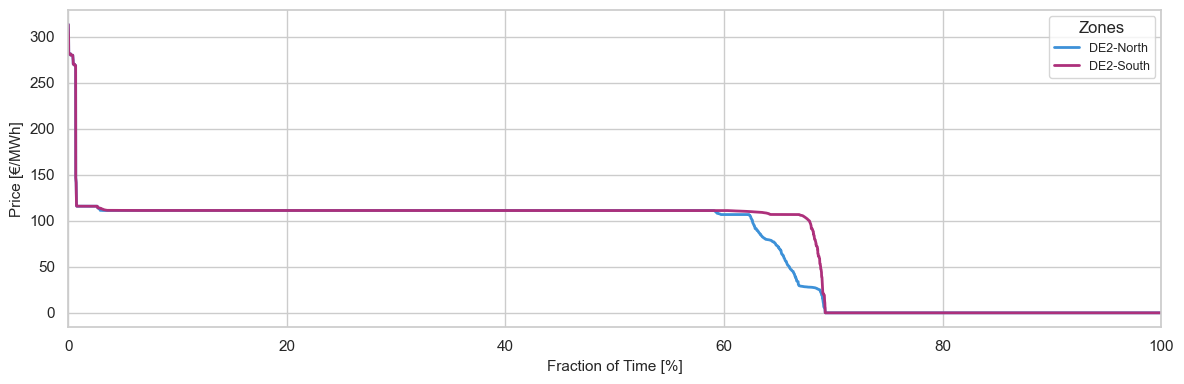

In [24]:
# Cell: Plot Price Duration Curves (PDCs) by zone

def plot_pdc_by_zone(net):
    """
    Plot Price Duration Curves (PDCs) by bidding zone.

    Parameters
    ----------
    net : pypsa.Network
        Network to analyze.
    """
    fig, ax = plt.subplots(figsize=(12, 4))

    zone_pdcs = get_metrics.get_pdc_by_zone(net)
    for zone, pdc in zone_pdcs.items():
        ax.plot(
            pdc.index, pdc.values,
            color=zone_colors.get(zone, "grey"),
            linewidth=2.0,
            label=zone,
        )

    ax.set_xlabel("Fraction of Time [%]", fontsize=11)
    ax.set_ylabel("Price [€/MWh]", fontsize=11)
    ax.set_xlim(0, 100)
    ax.grid(True)
    ax.legend(fontsize=9, title="Zones")
    plt.tight_layout()
    plt.show()

plot_pdc_by_zone(n_disp) # Define simulation stage here

In [20]:
# Cell: Compare CO2 shadow prices across scenarios or stages

nets = [n_capopt_full, n_capopt_limited, n_capopt_semiflex, n_disp] # Define scenarios/stages here
titles = ["Full Knowledge", "Limited Knowledge", "Semi-Flexible", "Dispatch"]

print("CO₂ Shadow Prices [€/tCO₂]")
for net, title in zip(nets, titles):
    co2_price = abs(net.global_constraints.loc["CO2Limit", "mu"])
    print(f"{title}: {co2_price:.2f}")

CO₂ Shadow Prices [€/tCO₂]
Full Knowledge: 69.26
Limited Knowledge: 60.89
Semi-Flexible: 79.96
Dispatch: 96.59


/var/folders/b8/z9v18hmn4x58qcsgkfvfd24h0000gn/T/ipykernel_4949/2398495896.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


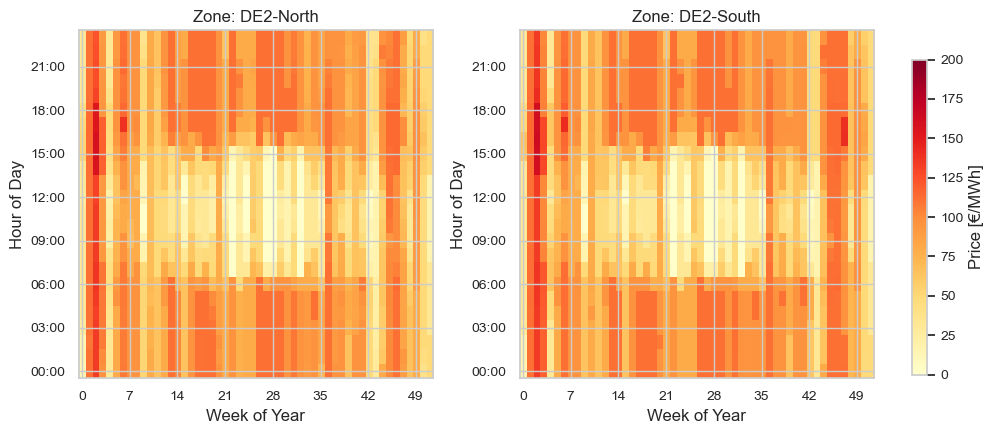

In [ ]:
# Cell: Plot heatmap of prices across the year (hour vs. week)

def plot_price_hour_week_grid(net):
    """
    Plot average zonal price as a heatmap of hour (0–23) vs. week (1–52).
    """
    zones = sorted(net.buses["zone"].unique())
    prices = net.buses_t.marginal_price.copy()

    n_zones = len(zones)
    n_cols = min(n_zones, 3)
    n_rows = math.ceil(n_zones / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4.5*n_rows), squeeze=False)

    for i, zone in enumerate(zones):
        ax = axes[i // n_cols, i % n_cols]

        zone_buses = net.buses.query("zone == @zone").index
        zone_prices = prices[zone_buses].mean(axis=1).resample("1h").mean()

        df = pd.DataFrame({"price": zone_prices})
        df["week"] = df.index.isocalendar().week
        df["hour"] = df.index.hour
        heatmap = df.groupby(["week", "hour"])["price"].mean().unstack()

        heatmap = heatmap.reindex(index=range(1, 53), columns=range(24))

        im = ax.imshow(
            heatmap.T, aspect="auto", cmap="YlOrRd", origin="lower",
            vmin=0, vmax=200
        )

        ax.set_title(f"Zone: {zone}", fontsize=12)
        ax.set_xlabel("Week of Year")
        ax.set_ylabel("Hour of Day")
        ax.set_xticks(range(0, 52, 7))
        ax.set_yticks(range(0, 24, 3))
        ax.set_yticklabels([f"{h:02d}:00" for h in range(0, 24, 3)])

    # Single colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="Price [€/MWh]")

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

plot_price_hour_week_grid(n_disp) # Define simulation stage here

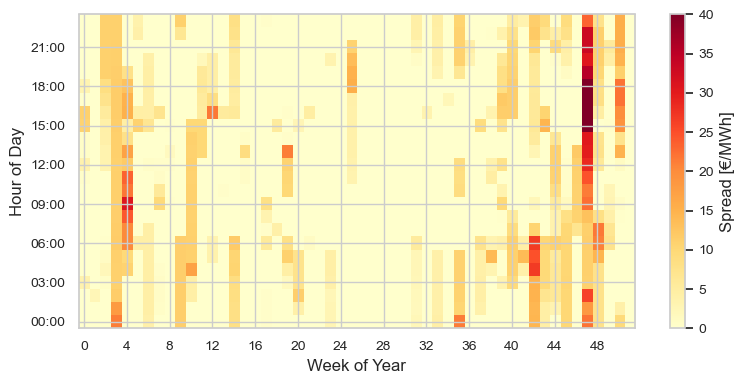

Max zonal spread: 84.20 €/MWh at 2013-11-24 13:00:00


In [22]:
# Cell: Plot heatmap of price difference between zones across the year

def plot_zonal_price_spread(net):
    """
    Plot heatmap of average zonal price spread by week and hour. 
    The spread is defined as the difference between the maximum and minimum zonal 
    prices at each time step.
    """
    bus_zones = net.buses["zone"]
    prices = net.buses_t.marginal_price.copy()
    zone_prices = prices.T.groupby(bus_zones).mean().T

    spread = (zone_prices.max(axis=1) - zone_prices.min(axis=1)).resample("1h").mean()

    df = pd.DataFrame({"spread": spread})
    df["week"] = df.index.isocalendar().week
    df["hour"] = df.index.hour
    heatmap = df.groupby(["week", "hour"])["spread"].mean().unstack()
    heatmap = heatmap.reindex(index=range(1, 53), columns=range(24))

    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(heatmap.T, aspect="auto", cmap="YlOrRd", origin="lower", vmin=0, vmax=40)

    ax.set_xlabel("Week of Year")
    ax.set_ylabel("Hour of Day")
    ax.set_xticks(range(0, 52, 4))
    ax.set_yticks(range(0, 24, 3))
    ax.set_yticklabels([f"{h:02d}:00" for h in range(0, 24, 3)])

    fig.colorbar(im, ax=ax, label="Spread [€/MWh]")
    plt.tight_layout()
    plt.show()

    # Diagnostic: max spread
    max_spread_time = spread.idxmax()
    max_spread_value = spread.max()
    print(f"Max zonal spread: {max_spread_value:.2f} €/MWh at {max_spread_time}")

plot_zonal_price_spread(n_disp) # Define simulation stage here

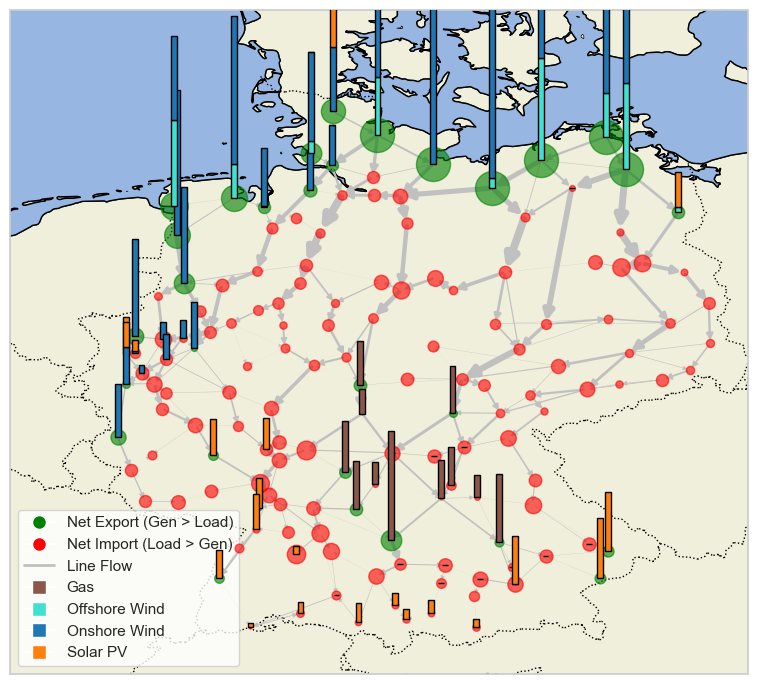

In [23]:
# Cell: Plot snapshot of congestion, generation, and net injection at a specific hour for analysis
from matplotlib.patches import FancyArrowPatch

def plot_congestion_snapshot(net, hour, tech_colors, generation_techs, ax, title=None):
    ax.set_extent([5, 15, 47, 56], crs=ccrs.PlateCarree())
    ax.add_feature(cf.BORDERS, linestyle=':')
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.LAND, edgecolor='black')
    ax.add_feature(cf.OCEAN)

    bus_locs = net.buses[['x', 'y']]

    # --- Generation per bus and technology ---
    gen_at_hour = net.generators_t.p.loc[hour]
    gen_df = net.generators.copy()
    gen_df['gen'] = gen_at_hour

    # --- Group generation by bus and carrier ---
    gen_by_bus_carrier = gen_df.groupby(['bus', 'carrier'])['gen'].sum().unstack(fill_value=0)

    # --- Load per bus ---
    load_at_hour = net.loads_t.p_set.loc[hour].groupby(net.loads.bus).sum()

    # --- Net injection ---
    net_injection = gen_by_bus_carrier.sum(axis=1).sub(load_at_hour, fill_value=0)

    # --- Draw multi-tech generation per bus ---
    for bus, row in gen_by_bus_carrier.iterrows():
        if bus not in bus_locs.index:
            continue
        x, y = bus_locs.loc[bus]
        bottom = y
        for tech, gen_val in row.items():
            if tech not in tech_colors:
                continue
            height = gen_val * 0.001
            if height > 0:
                ax.bar(x, height, width=0.08, bottom=bottom, color=tech_colors[tech],
                       transform=ccrs.PlateCarree(), zorder=10, edgecolor='black')
                bottom += height

    # --- Draw net injection as circle ---
    for bus, val in net_injection.items():
        if bus not in bus_locs.index:
            continue
        x, y = bus_locs.loc[bus]
        color = 'green' if val > 0 else 'red'
        size = min(abs(val) * 0.2, 600)
        ax.scatter(x, y, s=size, color=color, alpha=0.6, transform=ccrs.PlateCarree(), zorder=9)

    # --- Line flows at this hour ---
    flows = net.lines_t.p0.loc[hour]
    for line_id, flow in flows.items():
        line = net.lines.loc[line_id]
        x0, y0 = net.buses.loc[line.bus0, ['x', 'y']]
        x1, y1 = net.buses.loc[line.bus1, ['x', 'y']]

        dx, dy = x1 - x0, y1 - y0
        length = np.hypot(dx, dy)
        if length == 0:
            continue
        ux, uy = dx / length, dy / length

        width = abs(flow) * 0.0008
        color = 'silver'

        start_x, start_y = (x0, y0) if flow >= 0 else (x1, y1)
        end_x, end_y = (x1, y1) if flow >= 0 else (x0, y0)

        arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                arrowstyle='-|>',
                                color=color,
                                mutation_scale=6 + width * 2,
                                linewidth=width,
                                transform=ccrs.PlateCarree(),
                                zorder=6)
        ax.add_patch(arrow)

    # --- Legend ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Net Export (Gen > Load)',
               markerfacecolor='green', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Net Import (Load > Gen)',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], color='silver', lw=2, label='Line Flow'),
    ] + [
        Line2D([0], [0], marker='s', color='w', label=nice_names[tech],
               markerfacecolor=color, markersize=10)
        for tech, color in tech_colors.items() if tech in generation_techs
    ]
    ax.legend(handles=legend_elements, loc='lower left', fontsize=11)

    if title:
        ax.set_title(title, fontsize=14, pad=10)

hour = "2013-11-24 13:00:00" # Define hour of snapshot here
fig, ax = plt.subplots(1, 1, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
plot_congestion_snapshot(n_disp, # Define simulation stage here
                         hour, tech_colors, generation_techs, ax)
plt.tight_layout()
plt.show()

## 7. Cost Recovery

The section is structured as follows:
1. **Average CRF by asset type and zone** – overview of cost recovery performance at an aggregate level.  
2. **CRF of individual assets** – detailed analysis with boxplots and scatter overlays, showing the spread within each technology and zone.  
3. **Geographical mapping of CRF** – spatial representation of cost recovery patterns across Germany.

In [8]:
# Cell: Average CRF by asset type & zone
net = n_disp # Define simulation stage here

# Compute econ metrics
econ_metrics = get_metrics.get_economic_metrics(net, generation_techs, storage_techs)

# Compute CRF per zone x technology (ratio, e.g. 1.0 = 100%)
crf_by_zone = get_metrics.compute_crf_by_zone(net, econ_metrics, generation_techs, storage_techs)

# Display in percent with rounding
crf_pct = (crf_by_zone * 100).round(1)
crf_pct.index.name = "Zone"
print("Cost-Recovery Factor by Zone and Technology (in %):")
display(crf_pct)


Cost-Recovery Factor by Zone and Technology (in %):


technology,OCGT,solar,offwind-ac,onwind,battery
Zone,,,,,
DE2-North,89.2,105.6,120.8,121.4,101.4
DE2-South,90.5,109.9,NaN,116.9,99.4


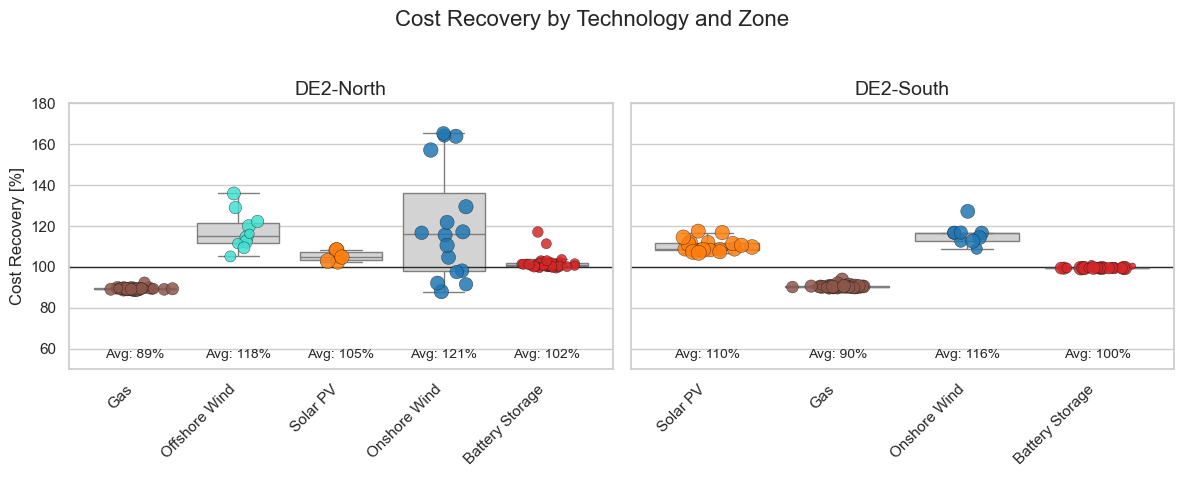

In [9]:
# Cell: Component-level cost recovery dataframe + plotting

def prepare_cost_recovery_df(net, generation_techs, storage_techs, min_generation_threshold=1000):
    """
    Prepare a DataFrame with component-level cost recovery and metadata.

    Returns columns: ['component', 'zone', 'technology', 'cost_recovery', 'p_nom_opt'].
    Filters components with 'Total Generation' > min_generation_threshold (units same as get_metrics output).
    """
    # Cost recovery series (index = component names)
    recovery_sr = get_metrics.calculate_cost_recovery(net, generation_techs, storage_techs)
    meta = get_metrics.build_component_metadata(net)
    df = meta.join(recovery_sr.rename("cost_recovery"), how="inner")
    df = df.reset_index().rename(columns={'index': 'component'})

    # Get p_nom_opt from generators and storage
    p_gen = net.generators.get('p_nom_opt', pd.Series(dtype=float))
    p_sto = net.storage_units.get('p_nom_opt', pd.Series(dtype=float))
    p_nom_opt = pd.concat([p_gen, p_sto]).rename('p_nom_opt')

    df = df.set_index('component').join(p_nom_opt, how='left').reset_index()

    # Filter by a minimal generation threshold (based on get_metrics.get_economic_metrics()['Total Generation'])
    total_gen = get_metrics.get_economic_metrics(net, generation_techs, storage_techs).get('Total Generation', pd.Series(dtype=float))
    relevant_components = total_gen[total_gen > min_generation_threshold].index
    df = df[df['component'].isin(relevant_components)].copy()

    return df[['component', 'zone', 'technology', 'cost_recovery', 'p_nom_opt']]


def plot_cost_recovery_by_zone(df, tech_colors, nice_names, title="Cost Recovery by Technology and Zone", y_lim=(50, 180)):
    """
    Box + scatter plot of cost recovery (components) per zone.
    - df must contain columns ['component','zone','technology','cost_recovery','p_nom_opt']
    - tech_colors : dict carrier -> color
    - nice_names : dict carrier -> display name
    """
    sns.set_theme(style="whitegrid")
    df = df.copy().dropna(subset=['cost_recovery'])
    df['cost_recovery_pct'] = df['cost_recovery'] * 100
    df['technology_label'] = df['technology'].map(nice_names).fillna(df['technology'])

    zones = sorted(df['zone'].dropna().unique())
    n_cols = max(1, len(zones))
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 5), sharey=True)
    if n_cols == 1:
        axes = [axes]

    # Compute average CRF per zone-tech for annotation
    avg_cr = df.groupby(['zone', 'technology_label'])['cost_recovery_pct'].mean().reset_index()

    for ax, zone in zip(axes, zones):
        zone_df = df[df['zone'] == zone].copy()
        if zone_df.empty:
            ax.set_visible(False)
            continue

        tech_order = zone_df['technology_label'].unique().tolist()

        # Boxplot (per technology)
        sns.boxplot(
            data=zone_df,
            x='technology_label',
            y='cost_recovery_pct',
            order=tech_order,
            showfliers=False,
            ax=ax,
            color='lightgray'
        )

        # Scatter with size reflecting p_nom_opt (log scale)
        sizes_raw = zone_df['p_nom_opt'].fillna(0).clip(lower=1.0)  # avoid log10(0)
        sizes_log = np.log10(sizes_raw)
        sizes_scaled = 20 + 100 * (sizes_log - sizes_log.min()) / (sizes_log.max() - sizes_log.min() + 1e-9)

        # Build color list from tech -> color mapping
        colors_list = zone_df['technology'].map(lambda t: tech_colors.get(t, '#888888'))

        # Jittered x positions for visibility
        x_positions = zone_df['technology_label'].map(lambda t: tech_order.index(t)).astype(float)
        x_jitter = np.random.normal(0, 0.12, size=len(x_positions))

        ax.scatter(
            x_positions + x_jitter,
            zone_df['cost_recovery_pct'],
            c=colors_list,
            s=sizes_scaled,
            edgecolors='k',
            linewidths=0.3,
            alpha=0.85,
            zorder=5
        )

        # Annotate average values per tech
        for _, row in avg_cr[avg_cr['zone'] == zone].iterrows():
            tech_label = row['technology_label']
            if tech_label in tech_order:
                x_pos = tech_order.index(tech_label)
                ax.text(x_pos, y_lim[0] + 10, f"Avg: {row['cost_recovery_pct']:.0f}%", ha='center', va='top', fontsize=10)

        ax.axhline(100, color='black', linestyle='-', linewidth=1.0, alpha=0.8)
        ax.set_title(zone, fontsize=14)
        ax.set_ylim(y_lim)
        ax.set_ylabel("Cost Recovery [%]")
        ax.set_xlabel("")
        ax.set_xticks(range(len(tech_order)))
        ax.set_xticklabels(tech_order, rotation=45, ha='right')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


df_cost = prepare_cost_recovery_df(n_disp, # Define simulation stage here
                                   generation_techs, storage_techs, min_generation_threshold=1000)
plot_cost_recovery_by_zone(df_cost, tech_colors=tech_colors, nice_names=nice_names)


## 8. Congestion & Redispatch

Redispatch costs consist of two main components:

1. **Capital and operational costs of additional gas plants**  
   - To ensure feasibility, additional OCGT (Open Cycle Gas Turbine) units are added specifically for redispatch flexibility.  
   - These costs include **annualized capital expenditures** as well as **operational expenditures** (fuel and CO₂ costs).  
   - Costs are calculated at the **zone level** and then distributed equally across all buses within each zone.  

2. **Costs from up- and down-dispatch of existing plants**  
   - **Up-dispatch**: Remunerated at the full marginal cost of generation (including CO₂ costs for OCGT).  
   - **Down-dispatch**: Compensated based on *lost market revenues* minus *saved marginal costs*.  
     - Lost market revenues are derived from the locational marginal prices (LMPs) in the original dispatch simulation.  

Redispatch costs are pooled nationally and distributed equally over all hours and zones (by load).


In [12]:
# Cell: Apply grid-efficient curtailment, analyze redispatch volumes and costs
# CALCULATION TIME: ~1-2 min expected due to grid-efficient curtailment algorithm

# --- Apply grid-efficient curtailment ---
n_redisp_eff = redispatch_calculation.apply_grid_efficient_curtailment(n_redisp, zones_disp)

# Define zones
zones = n_redisp.buses.zone.unique()

# --- Redispatch volumes ---
reserve_redisp_volume = redispatch_calculation.calculate_gas_reserve_volume(n_redisp_eff)
up_disp_volume, down_disp_volume = redispatch_calculation.calculate_up_down_dispatch_volume(n_redisp_eff)

# --- Redispatch costs ---
gas_reserve_costs = redispatch_calculation.calculate_gas_reserve_costs(n_redisp_eff, n_disp, zones)
up_down_dispatch_costs = redispatch_calculation.calculate_up_down_dispatch_costs(n_redisp_eff, n_disp, zones)

# --- Aggregate totals ---
total_redisp_volume = abs(down_disp_volume).sum().sum()
total_gas_reserve_volume = reserve_redisp_volume.sum().sum()

total_redisp_costs = gas_reserve_costs + up_down_dispatch_costs

# --- Print summary ---
print(f"Total Redispatch Volume: {total_redisp_volume/1e6:.1f} TWh")
print(f"Total Redispatch Costs: €{total_redisp_costs.sum().sum()/1e9:.2f} bn")

Total Redispatch Volume: 70.1 TWh
Total Redispatch Costs: €7.47 bn


In [13]:
# Cell: Analyze contributions to redispatch volumes and costs

print(
    f"\nGas Reserve Volume as Share of Total Redispatch Volume: "
    f"{(total_gas_reserve_volume/total_redisp_volume)*100:.2f} %"
)
print(
    f"Gas Reserve Dispatch Costs as Share of Total Redispatch Costs: "
    f"{(gas_reserve_costs.sum().sum()/total_redisp_costs.sum().sum())*100:.2f} %"
)

# --- Gas-specific share of up-dispatch ---
ocgt_up_disp_plants = n_redisp_eff.generators[
    (n_redisp_eff.generators.carrier == "OCGT")
    & (n_redisp_eff.generators.index.str.contains("ramp up"))
]
ocgt_up_disp_volume = (
    n_redisp_eff.generators_t.p[ocgt_up_disp_plants.index].sum().sum()
    + reserve_redisp_volume.sum().sum()
)

print(f"Total Gas Up-Dispatch Volume: {ocgt_up_disp_volume/1e6:.1f} TWh")
print(
    f"Share of Gas Up-Dispatch from Total Redispatch Volume: "
    f"{(ocgt_up_disp_volume/total_redisp_volume)*100:.2f} %"
)


Gas Reserve Volume as Share of Total Redispatch Volume: 12.20 %
Gas Reserve Dispatch Costs as Share of Total Redispatch Costs: 11.17 %
Total Gas Up-Dispatch Volume: 59.6 TWh
Share of Gas Up-Dispatch from Total Redispatch Volume: 84.98 %


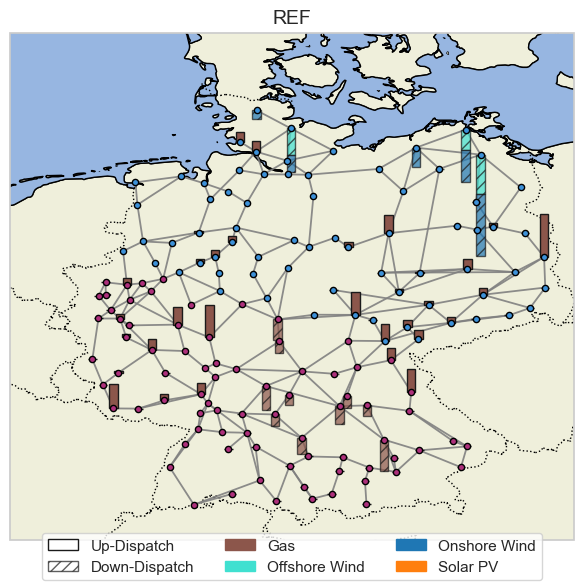

In [15]:
# Cell: Plot snapshot of redispatch (up- and down dispatch at each node per technology)

import matplotlib.patches as mpatches
def plot_up_down_dispatch(network, ax, hour, title):
    """
    Plot up- and down-dispatch per bus and carrier for a given snapshot.

    Args:
        network (pypsa.Network): Network with redispatch results.
        ax (matplotlib.axes.Axes): Axis object with cartopy projection.
        hour (str or pd.Timestamp): Snapshot to visualize.
        title (str): Plot title.

    Notes:
        - Up-dispatch is shown as positive bars above each bus.
        - Down-dispatch is shown as hatched bars below each bus.
        - Bars are stacked by technology using consistent colors.
    """
    bus_locs = network.buses[["x", "y"]]

    # --- Get dispatch volumes ---
    up_p, down_p = redispatch_calculation.calculate_up_down_dispatch_volume(network)

    # Build mapping from generators to (bus, tech)
    up_gen_map = {
        gen: (network.generators.loc[gen, "bus"], network.generators.loc[gen, "carrier"])
        for gen in up_p.columns
    }
    down_gen_map = {
        gen: (network.generators.loc[gen, "bus"], network.generators.loc[gen, "carrier"])
        for gen in down_p.columns
    }

    # --- Aggregate up- and down-dispatch per bus and tech ---
    net_dispatch = {}
    for bus in network.buses.index:
        net_dispatch[bus] = {}
        for tech in tech_colors.keys():
            up_gens = [g for g, (b, t) in up_gen_map.items() if b == bus and t == tech]
            down_gens = [g for g, (b, t) in down_gen_map.items() if b == bus and t == tech]
            up_val = up_p[up_gens].sum(axis=1)[hour] if up_gens else 0
            down_val = down_p[down_gens].sum(axis=1)[hour] if down_gens else 0
            net_dispatch[bus][tech] = up_val + down_val

    # Separate into positive (up) and negative (down)
    up_dispatch_sum = {
        bus: {tech: max(val, 0) for tech, val in techs.items()}
        for bus, techs in net_dispatch.items()
    }
    down_dispatch_sum = {
        bus: {tech: -min(val, 0) for tech, val in techs.items()}
        for bus, techs in net_dispatch.items()
    }

    # --- Plot map features ---
    ax.set_extent([5, 15, 47, 56], crs=ccrs.PlateCarree())
    ax.add_feature(cf.BORDERS, linestyle=":")
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.LAND, edgecolor="black")
    ax.add_feature(cf.OCEAN)

    bar_width = 0.15
    scaling_factor = 6e-4  # Controls relative bar size

    # --- Plot buses and dispatch bars ---
    for bus, (x, y) in bus_locs.iterrows():
        zone = network.buses.loc[bus, "zone"]
        ax.scatter(
            x,
            y,
            s=20,
            color=zone_colors.get(zone, "black"),
            edgecolor="black",
            zorder=15,
            transform=ccrs.PlateCarree(),
        )

        up_bottom = y
        down_bottom = y

        for tech in tech_colors.keys():
            # Up-dispatch: stacked bars upwards
            up_val = up_dispatch_sum[bus].get(tech, 0)
            if up_val > 0:
                height = up_val * scaling_factor
                ax.bar(
                    x,
                    height,
                    bar_width,
                    bottom=up_bottom,
                    color=tech_colors[tech],
                    edgecolor="k",
                    transform=ccrs.PlateCarree(),
                    zorder=10,
                )
                up_bottom += height

            # Down-dispatch: stacked bars downwards with hatching
            down_val = down_dispatch_sum[bus].get(tech, 0)
            if down_val > 0:
                height = down_val * scaling_factor
                ax.bar(
                    x,
                    -height,
                    bar_width,
                    bottom=down_bottom,
                    color=tech_colors[tech],
                    hatch="///",
                    edgecolor="k",
                    transform=ccrs.PlateCarree(),
                    zorder=10,
                    alpha=0.7,
                )
                down_bottom -= height

    # --- Plot transmission lines ---
    for _, line in network.lines.iterrows():
        x0, y0 = network.buses.loc[line.bus0, ["x", "y"]]
        x1, y1 = network.buses.loc[line.bus1, ["x", "y"]]
        ax.plot([x0, x1], [y0, y1], linewidth=1.3, color="gray", alpha=0.9, zorder=7)

    if title:
        ax.set_title(title, fontsize=14, pad=7)


# --- Example visualization for one hour ---
hour = "2013-11-24 13:00:00" # Define hour of snapshot here

fig, ax1 = plt.subplots(
    1, 1, figsize=(6, 6), subplot_kw={"projection": ccrs.PlateCarree()}
)

plot_up_down_dispatch(n_redisp_eff, ax1, hour, title="REF")

# Build legend
legend_elements = [
    mpatches.Patch(facecolor="white", edgecolor="k", hatch="", label="Up-Dispatch"),
    mpatches.Patch(
        facecolor="white", edgecolor="k", hatch="///", label="Down-Dispatch", alpha=0.7
    ),
] + [
    mpatches.Patch(color=c, label=nice_names[t])
    for t, c in tech_colors.items()
    if t != "battery"
]

fig.legend(handles=legend_elements, loc="lower center", ncol=3)

plt.tight_layout()
plt.show()


## 9. Consumer Prices

Consumer prices are calculated as the sum of:

1. **Wholesale Market Prices**:  
   Derived from the marginal price at each bus in the dispatch simulation.

2. **Redispatch Surcharge**:  
   Redispatch costs are socialized across all consumers. This includes:  
   - Capital and operational costs of additional gas reserve plants.  
   - Costs of up-dispatch (fuel + CO₂ costs) and compensation for down-dispatch (lost revenues – saved marginal costs).

**Key assumptions:**
- Redispatch costs are distributed proportionally to total load across the system.  

In [16]:
def calculate_consumer_prices(net_redisp, net_disp, net_reference):
    """
    Calculate consumer electricity prices including redispatch surcharges.

    Args:
        net_redisp (pypsa.Network): Redispatch simulation network.
        net_disp (pypsa.Network): Zonal dispatch simulation network.
        net_reference (pypsa.Network): Reference network for zone definitions.

    Returns:
        pd.DataFrame: Time series of consumer prices per zone [€/MWh].
    """
    zones = net_reference.buses["zone"].unique()
    consumer_prices_zone = pd.DataFrame(index=net_disp.snapshots)

    # --- Market price (zonal average of bus marginal prices) ---
    market_prices = net_disp.buses_t.marginal_price

    # --- System load (used to spread redispatch costs) ---
    total_load = (
        net_disp.statistics.withdrawal(comps=["Load"], groupby=["bus"], aggregate_time=False)
        .droplevel(0)
        .T.sum(axis=1)
    )

    # --- Redispatch costs (gas reserve + up/down redispatch) ---
    up_down_dispatch_costs = redispatch_calculation.calculate_up_down_dispatch_costs(net_redisp, net_disp, zones)
    gas_reserve_costs = redispatch_calculation.calculate_gas_reserve_costs(net_redisp, net_disp, zones)
    total_redisp_cost = (up_down_dispatch_costs + gas_reserve_costs).sum(axis=1)

    # --- Redispatch surcharge [€/MWh] ---
    redispatch_surcharge = (total_redisp_cost / total_load).mean()
    redispatch_surcharge = pd.Series(redispatch_surcharge, index=net_redisp.snapshots)

    # --- Add redispatch surcharge to zonal market price ---
    for zone in zones:
        zone_buses = net_reference.buses[net_reference.buses["zone"] == zone].index
        zone_market_price = market_prices[zone_buses].mean(axis=1)

        consumer_prices_zone[zone] = zone_market_price + redispatch_surcharge

    return consumer_prices_zone

In [18]:
# --- Calculate consumer prices including redispatch surcharge ---
consumer_prices = calculate_consumer_prices(n_redisp_eff, n_disp, n_disp)

# --- Print average values per zone ---
for zone in n_disp.buses.zone.unique():
    avg_price = consumer_prices[zone].mean()
    print(f"Average consumer price in zone {zone}: {avg_price:.2f} €/MWh")

Average consumer price in zone DE2-North: 87.84 €/MWh
Average consumer price in zone DE2-South: 90.79 €/MWh


## 10. Other Metrics & Plots

In [27]:
# Generator Surplus by Zone
gs = get_metrics.get_generator_surplus(n_disp)

for zone in n_disp.buses.zone.unique():
    zone_buses = n_disp.buses[n_disp.buses["zone"] == zone].index
    gs_zone = gs[zone_buses].sum().sum()
    print(f"Generator Surplus in Zone {zone}: €{gs_zone/1e9:.2f} bn")

Generator Surplus in Zone DE2-North: €18.19 bn
Generator Surplus in Zone DE2-South: €12.89 bn


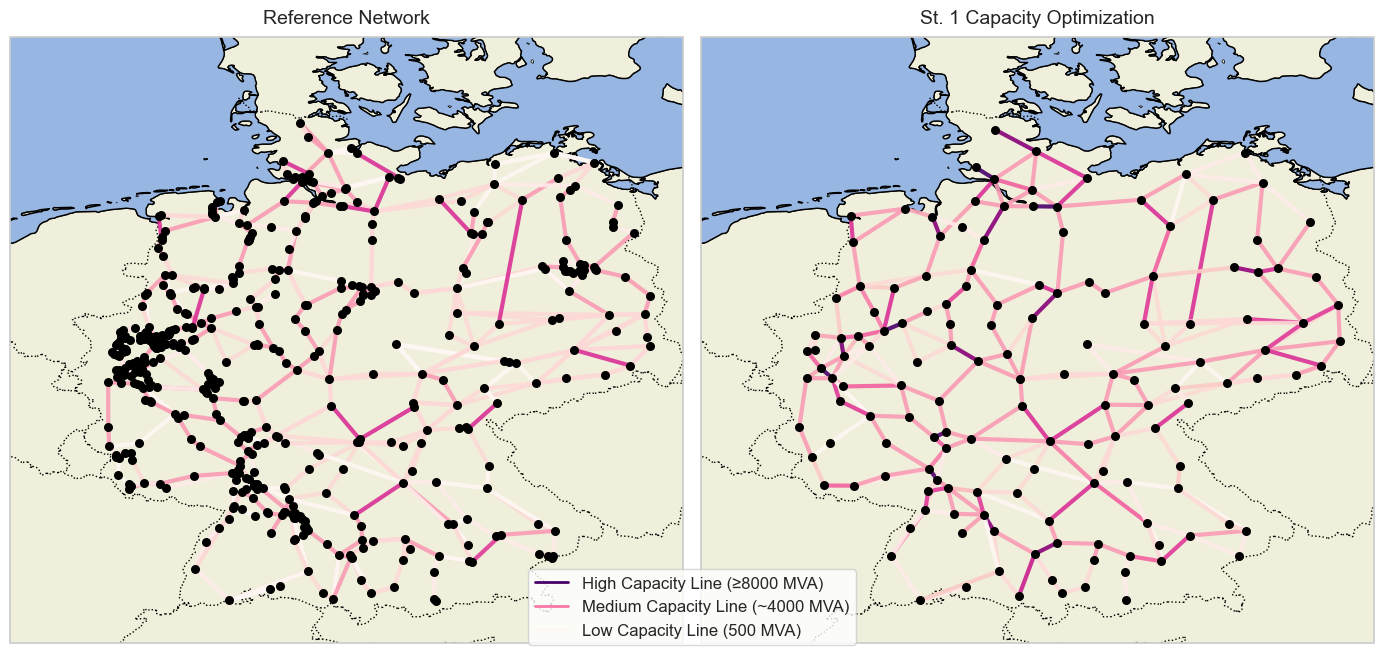

In [29]:
# Comparison of grid capacities of optimization with real-world approximation

from matplotlib.lines import Line2D
def plot_network_capacities(net, ax, title):
    bus_locs = net.buses[['x', 'y']]

    ax.set_extent([5, 15, 47, 56], crs=ccrs.PlateCarree())
    ax.add_feature(cf.BORDERS, linestyle=':')
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.LAND, edgecolor='black')
    ax.add_feature(cf.OCEAN)

    for bus, (x, y) in bus_locs.iterrows():
        if "zone" in net.buses.columns:
            zone = net.buses.loc[bus, 'zone']
        else:
            zone = 'Nodal'
        ax.scatter(x, y, s=30, color=zone_colors[zone], edgecolor='black', zorder=15, transform=ccrs.PlateCarree())

    for _, line in net.lines.iterrows():
        x0, y0 = net.buses.loc[line.bus0, ['x', 'y']]
        x1, y1 = net.buses.loc[line.bus1, ['x', 'y']]

        s_nom = line.s_nom
        # Use a colormap to enhance line capacity differences visually
        cmap = mpl.colormaps.get_cmap("RdPu")
        min_cap, max_cap = 500, 8000
        norm = mpl.colors.Normalize(vmin=min_cap, vmax=max_cap)

        if s_nom >= max_cap:
            color = cmap(1.0)
            alpha = 1.0
        elif s_nom >= min_cap:
            color = cmap(norm(s_nom))
            alpha = 0.7
        else:
            color = cmap(0.0)
            alpha = 0.3
        ax.plot([x0, x1], [y0, y1], linewidth=3, color=color, alpha=0.9, zorder=7)

    if title:
        ax.set_title(title, fontsize=14, pad=10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})

plot_network_capacities(n_input, ax1, "Reference Network")
plot_network_capacities(n_capopt_full, ax2, "St. 1 Capacity Optimization")

# Use RdPu colormap for legend colors
cmap = mpl.colormaps.get_cmap("RdPu")
min_cap, max_cap = 500, 8000
norm = mpl.colors.Normalize(vmin=min_cap, vmax=max_cap)

legend_elements = [
    Line2D([0], [0], color=cmap(norm(8000)), lw=2, label='High Capacity Line (≥8000 MVA)'),
    Line2D([0], [0], color=cmap(norm(4000)), lw=2, label='Medium Capacity Line (~4000 MVA)'),
    Line2D([0], [0], color=cmap(norm(500)), lw=2, label='Low Capacity Line (500 MVA)'),
]

fig.legend(handles=legend_elements, loc='lower center', ncol=1, fontsize=12)

plt.tight_layout(rect=[0, -0.3, 1, 1])
plt.show()

/var/folders/b8/z9v18hmn4x58qcsgkfvfd24h0000gn/T/ipykernel_6140/552718161.py:11: RuntimeWarning: divide by zero encountered in log
  return np.exp(k - epsilon * np.log(p))


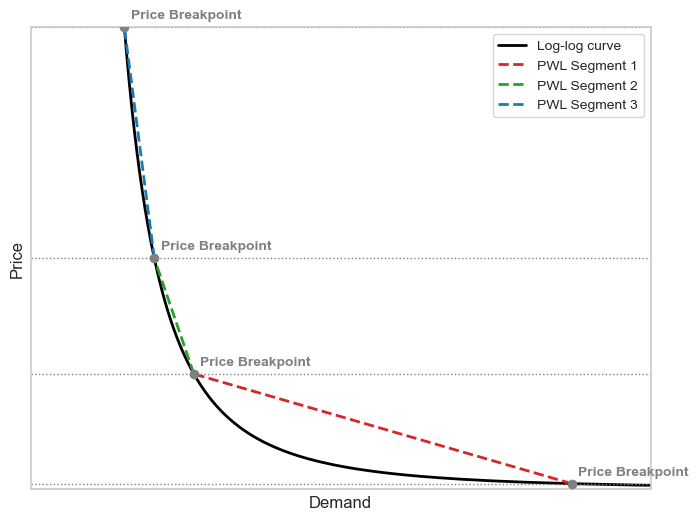

<Figure size 800x500 with 0 Axes>

In [ ]:
# Illustration of piecewise linear approximation for the readme file

# Parameters
epsilon = 0.4       # demand elasticity
k = 7                # scaling parameter (adjust as needed)
p_min, p_max = 10, 800   # price range of interest

# Define function: log(p) = (k - log(D)) / epsilon  =>  D(p)
def demand_from_price(p, epsilon=epsilon, k=k):
    return np.exp(k - epsilon * np.log(p))

# Generate true curve
p_vals = np.linspace(p_min-10, p_max+200, 400)
D_vals = demand_from_price(p_vals)

# Piecewise breakpoints in price
breaks = [10, 200, 400, 800]
segment_colors = ['tab:red', 'tab:green', 'tab:blue']

# Build piecewise approximations (linear in D–p space)
segments = []
for i in range(len(breaks)-1):
    p0, p1 = breaks[i], breaks[i+1]
    D0, D1 = demand_from_price(np.array([p0, p1]))
    segments.append(((D0, p0), (D1, p1)))

# Plot
fig, ax = plt.subplots(figsize=(8,6))

# True curve
ax.plot(D_vals, p_vals, label="Log-log curve", color="black", linewidth=2)

# Piecewise approximations
for idx, (seg, col) in enumerate(zip(segments, segment_colors), 1):
    (D0, p0), (D1, p1) = seg
    ax.plot([D0, D1], [p0, p1], color=col, linestyle="--", linewidth=2,
            label=f"PWL Segment {idx}")

# Breakpoint markers
for bp in breaks:
    Dbp = demand_from_price(bp)
    ax.axhline(bp, color="gray", linestyle=":", linewidth=1)
    ax.scatter(Dbp, bp, color="gray", zorder=5)

# Annotate breakpoints with text
for i, bp in enumerate(breaks):
    Dbp = demand_from_price(bp)
    # Build annotation string and colors
    txt = "Price Breakpoint"
    ax.text(Dbp + 5, bp + 10, txt, color="gray", fontsize=10, va="bottom", fontweight="bold")

# Formatting
ax.set_xlabel("Demand")
ax.set_ylabel("Price")
ax.set_ylim(0, 800)
ax.set_xlim(0, 500)
ax.set_xticks([])
ax.set_yticks([])
ax.legend()

plt.show()

plt.savefig("readme_pwl_curve.png", dpi=300, bbox_inches="tight")

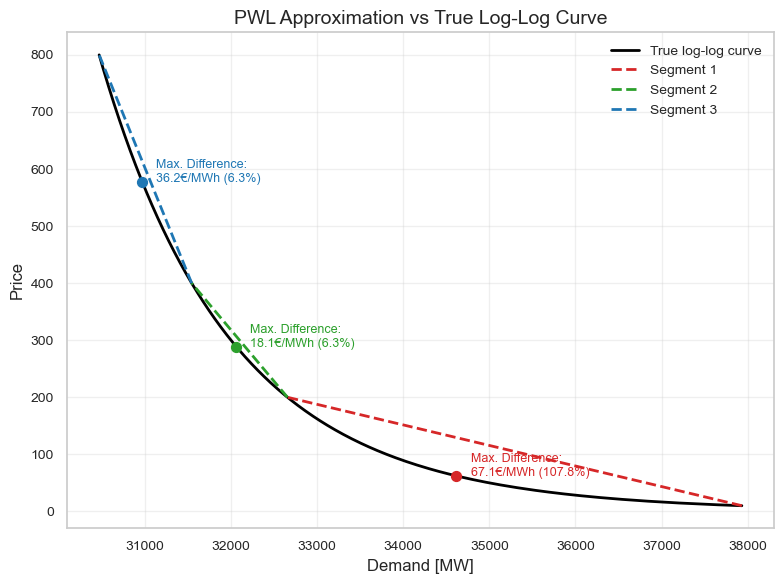

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect_right

def plot_pwl_vs_true(rp_new, config, n_samples=200):
    """
    Plot true log-log demand curve and PWL segments, showing
    maximum deviations per segment.

    Parameters
    ----------
    rp_new : tuple(float, float)
        Reference point (demand, price) for the current time step.
    config : dict
        Must contain:
            config["elasticities"]["lower_bound"]
            config["elasticities"]["elasticity"]
            config["elasticities"]["segments_p"]
    n_samples : int
        Number of samples per segment for deviation evaluation.
    """
    epsilon_bounds_lower = config["elasticities"]["lower_bound"]
    epsilon_values = config["elasticities"]["elasticity"]
    segments_p = [(float(a), float(b)) for a, b in config["elasticities"]["segments_p"]]

    # Reference values
    D_new = max(rp_new[0], 1e-10) 
    p_new = max(rp_new[1], 1e-10) 
    epsilon = epsilon_values[bisect_right(epsilon_bounds_lower, p_new) - 1] 
    k_new = np.log(D_new) - epsilon * np.log(p_new) 

    # Demand as function of price
    def D_of_p(p):
        return np.exp(k_new + epsilon * np.log(p))

    # Inverse: price as function of demand
    def p_of_D(D):
        return np.exp((np.log(D) - k_new) / epsilon)

    # Prepare plot
    fig, ax = plt.subplots(figsize=(8,6))

    # Plot true curve (cover slightly beyond segment range)
    p_vals = np.linspace(min(b[0] for b in segments_p),
                         max(b[1] for b in segments_p),
                         500)
    D_vals = D_of_p(p_vals)
    ax.plot(D_vals, p_vals, color="black", linewidth=2, label="True log-log curve")

    # Colors for segments
    colors = ["tab:red", "tab:green", "tab:blue", "tab:orange"]

    for i, (p0, p1) in enumerate(segments_p):
        # Demand at endpoints
        D0, D1 = D_of_p(np.array([p0, p1]))

        # Linear segment (in D–p space)
        slope = (p1 - p0) / (D1 - D0)
        intercept = p0 - slope * D0

        # Sample within segment
        D_samples = np.linspace(D0, D1, n_samples)
        p_true = p_of_D(D_samples)
        p_approx = slope * D_samples + intercept

        # Deviations
        abs_dev = np.abs(p_true - p_approx)
        rel_dev = abs_dev / np.maximum(p_true, 1e-12)
        max_idx = np.argmax(abs_dev)

        # Plot segment line
        ax.plot([D0, D1], [p0, p1],
                color=colors[i % len(colors)], linestyle="--", linewidth=2,
                label=f"Segment {i+1}")

        # Mark max deviation point
        ax.scatter(D_samples[max_idx], p_true[max_idx],
                   color=colors[i % len(colors)], marker="o", s=50, zorder=5)
        ax.text(D_samples[max_idx]*1.005, p_true[max_idx],
                f"Max. Difference:\n{abs_dev[max_idx]:.1f}€/MWh ({rel_dev[max_idx]*100:.1f}%)",
                color=colors[i % len(colors)], fontsize=9)

    # Labels and styling
    ax.set_xlabel("Demand [MW]")
    ax.set_ylabel("Price")
    ax.set_title("PWL Approximation vs True Log-Log Curve")
    ax.legend(frameon=False)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


conf = {
"elasticities": {
    "lower_bound": [0, 50, 200],
    "elasticity": [-0.04, -0.05, -0.06],
    "segments_p": [(10, 200), (200, 400), (400, 800)]
}
}
ref_point = (35000, 50)  # Example reference demand & price

deviations = plot_pwl_vs_true(ref_point, conf)
